In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
import numpy as np
import os
import anndata
import scipy
from typing import Optional, Union, List, Sequence, Mapping, Any, Tuple


sc.logging.print_header()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, color_map="Reds")
pl.rcParams['figure.figsize'] = [4,4]
%config InlineBackend.figure_format='retina'

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.1.3 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


# Define some functions

In [2]:
def import_cellranger_aggrcsv(adata, aggr_csv='aggregation.csv', key_added='Sample'):

    sample_numbers = adata.obs.index.str.replace('[ATGC]*-','')
    num_samps_in_matrix = len(sample_numbers.unique())

    aggr = pd.read_csv(aggr_csv)
    sample_id_column = aggr.columns[0]
    aggr['Sample_Num'] = aggr.index + 1
    aggr['Sample_Num'] = aggr['Sample_Num'].astype(str)
    num_samps_in_aggrcsv = len(aggr['Sample_Num'].unique())
    
    if num_samps_in_matrix == num_samps_in_aggrcsv:
        sampdict = dict(zip(aggr['Sample_Num'],aggr[sample_id_column]))
        adata.obs[key_added] = sample_numbers.map(sampdict)
        print('Detected {} GEM groups. Adding key \'{}\' to obs dataframe.'.format(num_samps_in_matrix,key_added))
        
    else: 
        print('Warning: Number of samples detected in your data matrix differs from the number in the provided aggregation.csv file')

        
def matrix_to_df(adata, layer='X', 
                 gene_name_key=None
                ):
    from scipy.sparse import issparse
    
    valid_layers = ['X','raw'] + list(adata.layers.keys())
    assert layer in valid_layers, 'layer must be either: X, raw, or a layer in adata.layers'
    
    if layer == 'X':
        print('Using scaled data in adata.X')
        if issparse(adata.X):
            df = pd.DataFrame(adata.X.toarray())
        else: 
            df = pd.DataFrame(adata.X)
        
    elif layer == 'raw':
        print('Using raw lognorm data in adata.raw')
        if issparse(adata.raw.X):
            df = pd.DataFrame(adata.raw.X.toarray())
        else: 
            df = pd.DataFrame(adata.raw.X)
            
    elif layer == 'df':
        if issparse(adata.layers[layer]):
            df = pd.DataFrame(np.floor(adata.layers[layer].toarray()).astype('float64'))
        else: 
            df = pd.DataFrame(np.floor(adata.layers[layer]).astype('float64'))
    
    elif layer in adata.layers:
        if issparse(adata.layers[layer]):
            df = pd.DataFrame(adata.layers[layer].toarray())
        else: 
            df = pd.DataFrame(adata.layers[layer])
    
    else:
        print('Warning, layer',layer,'not found in adata.layers')
    
    if str(df.__class__) == "<class 'pandas.core.frame.DataFrame'>":
        if layer != 'raw':
            if not gene_name_key:
                df.columns = adata.var_names
            else:
                df.columns = np.array(adata.var[gene_name_key])
            df.index = adata.obs.index
        else:
            if not gene_name_key:
                df.columns = adata.raw.var_names
                shared_genes = adata.var_names.intersection(adata.raw.var_names)
            else:
                df.columns = adata.raw.var[gene_name_key]
                shared_genes = list(set(adata.var[gene_name_key]).intersection(set(adata.raw.var[gene_name_key])))
            df.index = adata.raw.obs_names

            shared_cells = adata.obs_names.intersection(adata.raw.obs_names)
            df = df.loc[shared_cells,shared_genes]
        
    return df



def markers_for_SVM(
    adata: anndata.AnnData,
    groupby='Cluster',
    n_genes=50, 
    pval_adj_thresh=1e-6, 
    min_fold_change=0,
):

    sc.tl.rank_genes_groups(adata, groupby=groupby)
    cluster_names = sorted(adata.obs[groupby].unique().tolist())
    
    markerGenes = []
    
    for i in cluster_names:
        df = sc.get.rank_genes_groups_df(adata, group=i)
        df = df.query('pvals_adj < @pval_adj_thresh & logfoldchanges > @min_fold_change')
        markerGenes += df.sort_values(by='logfoldchanges',ascending=False)[:n_genes]['names'].tolist()
    
    return list(set(markerGenes))


def transfer_cell_types_svm(
    adata_ref: anndata.AnnData, 
    adata_target: anndata.AnnData, 
    cell_type_key, 
    n_features=50, 
    pval_adj_thresh=1e-6, 
    kernel='linear', 
    output_key='Predicted_Cell_Type', 
    groupby_cluster=None
    ):
    
    """
    This function selects highly differentially expressed marker genes from a reference dataset,
    and uses those as a limited feature set to train a SVM classifier on a new target dataset.
    Empirically, the gaussian radial basis function kernel seems to return the best precision, accuracy, and recall
    """
    
    from sklearn.model_selection import train_test_split
    from sklearn import svm

    train = adata_ref.copy()
    train.var_names_make_unique()
    target = adata_target.copy()
    
    #assertions
    assert cell_type_key in train.obs.select_dtypes('category').columns, 'cell_type_key must be a categorical column in adata.obs.  Available options: ' + str(train.obs.select_dtypes('category').columns.tolist())
    assert kernel in ['linear','poly','rbf'], 'kernel must be one of [\'linear\',\'poly\',\'rbf\']'
    if groupby_cluster:
        assert groupby_cluster in target.obs.select_dtypes('category').columns, 'groupby_cluster must be a categorical column in adata.obs.  Available options: ' + str(train.obs.select_dtypes('category').columns.tolist())
    
    kernel_text_dict = {'linear':' a linear kernel','poly':' a polynomial kernel','rbf':' a gaussian kernel'} 
    print('Generating an SVM using {} ...'.format(kernel_text_dict[kernel]))
    
    
    print('Generating log(CPM + 1) matrix...')
    
    if train.raw:
        print('Using raw data in adata_train.raw')
        genes_exlusive_to_raw = train.var_names.difference(train.raw.var_names)
        if len(genes_exlusive_to_raw) > 0:
            print('Excluding genes not appearing in processed data frame:',genes_exlusive_to_raw)
            train = train[:,genes_exlusive_to_raw].copy()
            train.X = train.raw.X
            
        else:
            print("adata.raw.var_names matches adata.var_names")
            train.X = train.raw.X
            
    elif 'counts' in train.layers:
        train.X = train.layers['counts']
        sc.pp.normalize_total(train, target_sum=1e4)
        sc.pp.log1p(train)

    #Identify marker genes in training dataset that distinguish the clusters to be transferred
    sc.tl.rank_genes_groups(train, groupby=cell_type_key)
    empirical_markers = markers_for_SVM(train, groupby=cell_type_key, n_genes=n_features, pval_adj_thresh=pval_adj_thresh)

    #deduplicate marker genes in test data
    empirical_markers = list(set([name for name in empirical_markers if name in train.var_names]))
    
    # exclude marker genes not occurring in target data
    filtered_markers = list(set(empirical_markers).intersection(target.var_names))
    n_excluded = len(empirical_markers) - len(filtered_markers)

    print('Excluding {} marker genes that do not appear in target dataset'.format(n_excluded))
    print('Excluded genes:', list(set(empirical_markers).difference(set(filtered_markers))))
    print("Number of marker genes used:",len(filtered_markers))
          
    empirical_cell_types = train.obs[cell_type_key]

    # Set up gene expression dataframe.  Use lognorm (i.e. "raw", in Scanpy terminology) data by default. 
    df = matrix_to_df(train[:,filtered_markers], layer='raw')
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(df, empirical_cell_types, test_size=0.3,random_state=42) # 70% training and 30% test

    #Create a svm classifier object
    clf = svm.SVC(kernel=kernel) 

    #Train the model using the training sets
    print('Training model using n_features = {} per cell type'.format(n_features))
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics

    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred, average='weighted')
    rec = metrics.recall_score(y_test, y_pred, average='weighted')
    
    print('Accuracy:', acc)
    print('Precision:',prec)
    print('Recall:',rec)

    print('Predicting class in adata_target...')
    target_data = matrix_to_df(target[:,filtered_markers], layer='raw')
    SVM_prediction = clf.predict(target_data)
    
    print("Adding predicted cell type to adata.obs[\'" + str(output_key) + "\']")
    adata_target.obs[output_key] = SVM_prediction
    
    if groupby_cluster:
        df = pd.crosstab(adata_target.obs[groupby_cluster],adata_target.obs[output_key])
        cluster_dict = dict(zip(df.index.tolist(), df.idxmax(1).tolist()))
        adata_target.obs[output_key + '_grouped'] = adata_target.obs[groupby_cluster].copy()
        adata_target.obs = adata_target.obs.replace({output_key + '_grouped':cluster_dict})
        
    # Visualize the results with an available embedding:
    if 'X_umap' in adata_target.obsm.keys():
        sc.pl.umap(adata_target, color=output_key)
        if groupby_cluster:
            sc.pl.umap(adata_target, color=output_key + '_grouped')
        
    elif 'X_tsne' in adata_target.obsm.keys():
        sc.pl.tsne(adata_target, color=output_key)
        if groupby_cluster:
            sc.pl.tsne(adata_target, color=output_key + '_grouped')

# Haber, Regev reference data

https://singlecell.broadinstitute.org/single_cell/study/SCP44/small-intestinal-epithelium#study-download

In [3]:
def scanpy_recipe(
    adata: anndata.AnnData,
    max_pcs: int = 50, # Total number of PCs to compute and retain. ,
    n_pcs: int = 50, # Number of PCs to use for neighbor graph calculation,
    knn = 15, # Number of PCs to use for neighbor graph calculation,
    min_genes: int = 1,
    min_counts: int = 1,
    min_cells: int = 1,
    mito_max: float = None,
    cluster_resolution: float = 0.5,
    n_top_genes: int = 4000,
    use_highly_variable: bool = True,
    hvg_batch_key=None,
    max_scale_value: Union[int, float] = 10,
    random_state: int = 0,
    target_sum = 1e4,
    reduce_dimensionality: bool = True,
    cluster_key = 'Cluster',
):
    
    if adata.var_names.duplicated().any():
        adata.var_names_make_unique()
        
    sc.pp.calculate_qc_metrics(adata, inplace=True)

    mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
    Rpl_genes = [name for name in adata.var_names if name.startswith('Rpl')]
    Rps_genes = [name for name in adata.var_names if name.startswith('Rps')]
    ribo_genes = Rpl_genes + Rps_genes


    adata.layers['counts'] = adata.X.astype('int64')
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
    adata.obs['percent_ribo'] = np.sum(adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)

    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_cells(adata, min_counts=min_counts)
    sc.pp.filter_genes(adata, min_cells=min_cells)

    if mito_max:
        print('Filtering cells with fraction mitochondrial reads > {}'.format(mito_max))
        adata = adata[adata.obs['percent_mito'] < mito_max].copy()


    adata.uns['Normalization_target_sum'] = int(target_sum)
    sc.pp.normalize_total(adata, target_sum=target_sum, exclude_highly_expressed=True, key_added='Norm_Factor')
    sc.pp.log1p(adata)
    adata.raw = adata.copy()
    
    # Dimensionality reduction section:
    if reduce_dimensionality:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, batch_key=hvg_batch_key)

        print("Masking ribosomal and mitochondrial genes from highly variable...")
        adata.var.highly_variable = adata.var.highly_variable.mask(adata.var.index.isin(ribo_genes), False)
        adata.var.highly_variable = adata.var.highly_variable.mask(adata.var.index.isin(mito_genes), False)

        sc.pp.scale(adata, max_value=max_scale_value)    
        sc.pp.pca(adata, n_comps = max_pcs, use_highly_variable=use_highly_variable, random_state=random_state)
        sc.pp.neighbors(adata, n_pcs=max_pcs, n_neighbors = knn, random_state=random_state)
        sc.tl.umap(adata, random_state=random_state)
        sc.tl.tsne(adata, random_state=random_state)
        sc.tl.leiden(adata,resolution=cluster_resolution, key_added=cluster_key, random_state=random_state)
        sc.pl.umap(adata, color=cluster_key)
    
    return adata

/opt/miniconda3/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)


... storing 'Mouse' as categorical
... storing 'Cluster' as categorical
... storing 'nGene' as categorical
... storing 'Regev_Cluster' as categorical


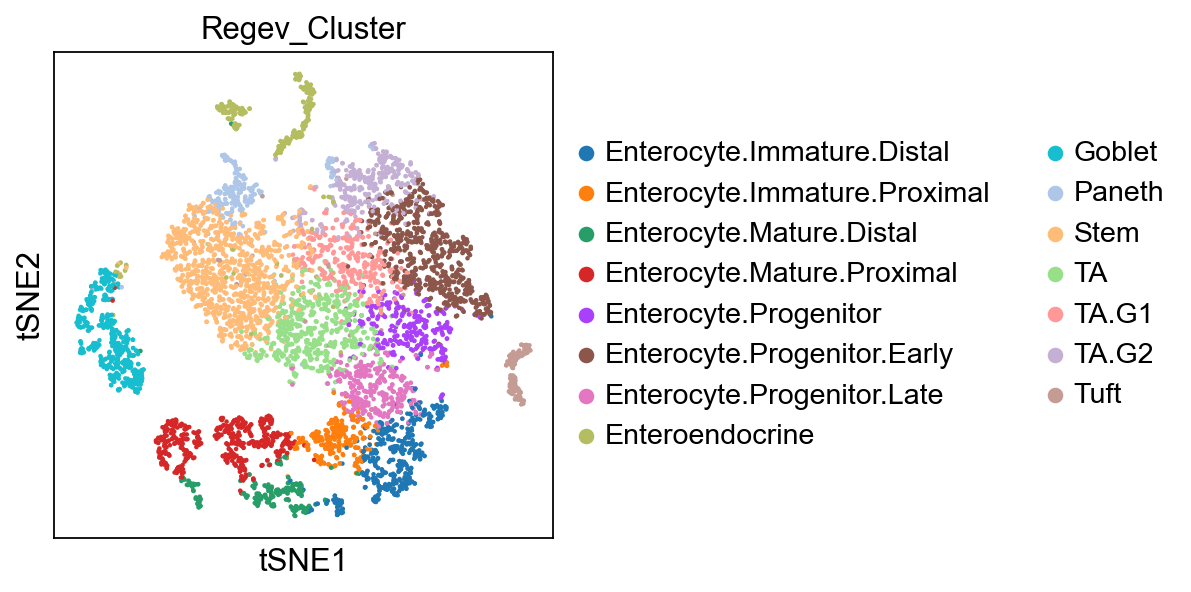

In [4]:
# Read in data matrix and sparsify
reg = sc.read_text('/Users/jpreall/Dropbox/Preall_Lab/External/Published_scRNAseq/Haber_Regev_Intestine/atlas_Log2Tpm_round2.txt').T
reg.X = scipy.sparse.csr_matrix(reg.X)

# Import metadata
meta = pd.read_table('/Users/jpreall/Dropbox/Preall_Lab/External/Published_scRNAseq/Haber_Regev_Intestine/atlas_metadata.txt').drop(index=0).set_index('NAME')
meta = meta.loc[reg.obs_names,['Mouse','Cluster','nGene','Cell-cycle']]
reg.obs = meta

# Stash cluster labels so they aren't overwritten by our recipe
reg.obs['Regev_Cluster'] = meta['Cluster']

# Import published tSNE and PCA projections
TSNE_PCA_FILE = '/Users/jpreall/Dropbox/Preall_Lab/External/Published_scRNAseq/Haber_Regev_Intestine/atlas_tSNE_PCA_update.txt'
TSNE_PCA = pd.read_table(TSNE_PCA_FILE, skiprows=[1], index_col=0)
reg.obsm['X_tsne'] = TSNE_PCA[['X','Y']].values
reg.obsm['X_pca'] = TSNE_PCA[['PC1','PC2','PC3','PC4','PC5']].values

# Process with standard recipe so we can call differential expressed genes. Skip dimensionality reduction
reg = scanpy_recipe(reg, reduce_dimensionality=False)

# Make sure that we can reproduce the tSNE plot from the publication
sc.pl.tsne(reg, color='Regev_Cluster')

#reg.write('/Users/jpreall/Dropbox/Preall_Lab/External/Published_scRNAseq/Haber_Regev_Intestine/Haber_intestine_atlas.h5ad', compression='gzip')


# C11orf53 knockout scRNAs-seq replicate 1

reading aggr/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Detected 2 GEM groups. Adding key 'Sample' to obs dataframe.
XW01_WT    7807
XW01_KO    6364
Name: Sample, dtype: int64
filtered out 10667 genes that are detected in less than 1 cells
Filtering cells with fraction mitochondrial reads > 0.2
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Itln1', 'Gcg', 'Chgb', 'Reg4', 'Fabp2', 'Clca1', 'Spink4', 'Jchain', 'Igkc', 'Reg3b', 'Reg1', 'Ghrl', 'Fcgbp', 'Hbb-bt', 'Hbb-bs', 'Zg16', 'Sct', 'Muc2', 'Defa21', 'Gm14851', 'Defa30', 'Defa22', 'AY761184', 'Defa24', 'Apoa1', 'Cck', 'Nts', 'Lyz2', 'Lyz1', 'Hba-a1', 'Hba-a2', 'Fabp6', 'Ccl5', 'Ccl4', 'Gip', 'Agr2', 'Chga', 'Igha', 'Ighg2b', 'Ighg3', 'Ighm', 'Gzma', 'Mcpt1', 'Mcpt2', 'Gzmb', 'Olfm4', 'Iglc1', 'Iglc2', 'Sst', 'Tff3', 'Tff2', 'Gm26917', 'Gm42418', 'Cd74', 'Malat1', 'Fth1', 'Tmsb4x', 'mt-Co1', 'mt-Co3', 'mt-Cytb']
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable

/opt/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:41)
running Leiden clustering
    finished: found 18 clusters and added
    'Cluster', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'Sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


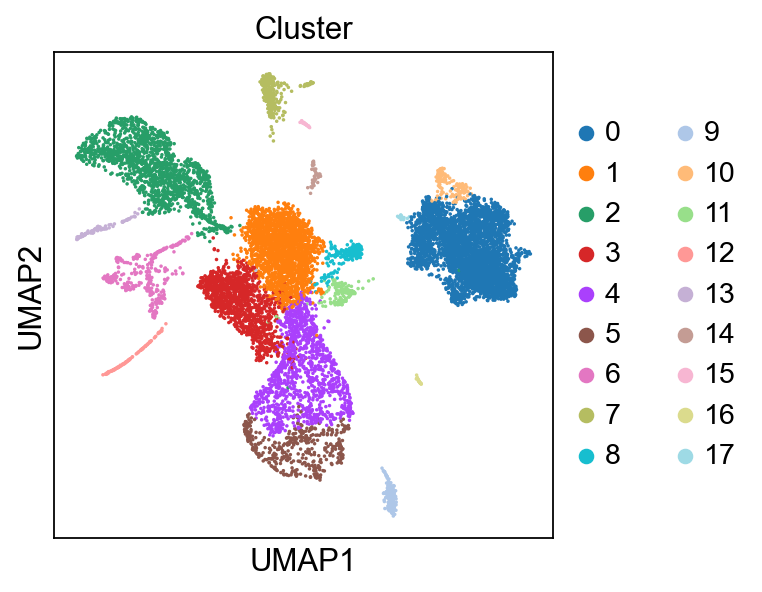

In [8]:
adata1 = sc.read_10x_h5('aggr/filtered_feature_bc_matrix.h5')
import_cellranger_aggrcsv(adata1, 'aggr/aggregation.csv')
adata1.obs['Sample'] = adata1.obs['Sample'].str.replace('XW01_10xGEX_intestine_','')
print(adata1.obs['Sample'].value_counts())

adata1 = scanpy_recipe(adata1, mito_max=0.2)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Cluster']`


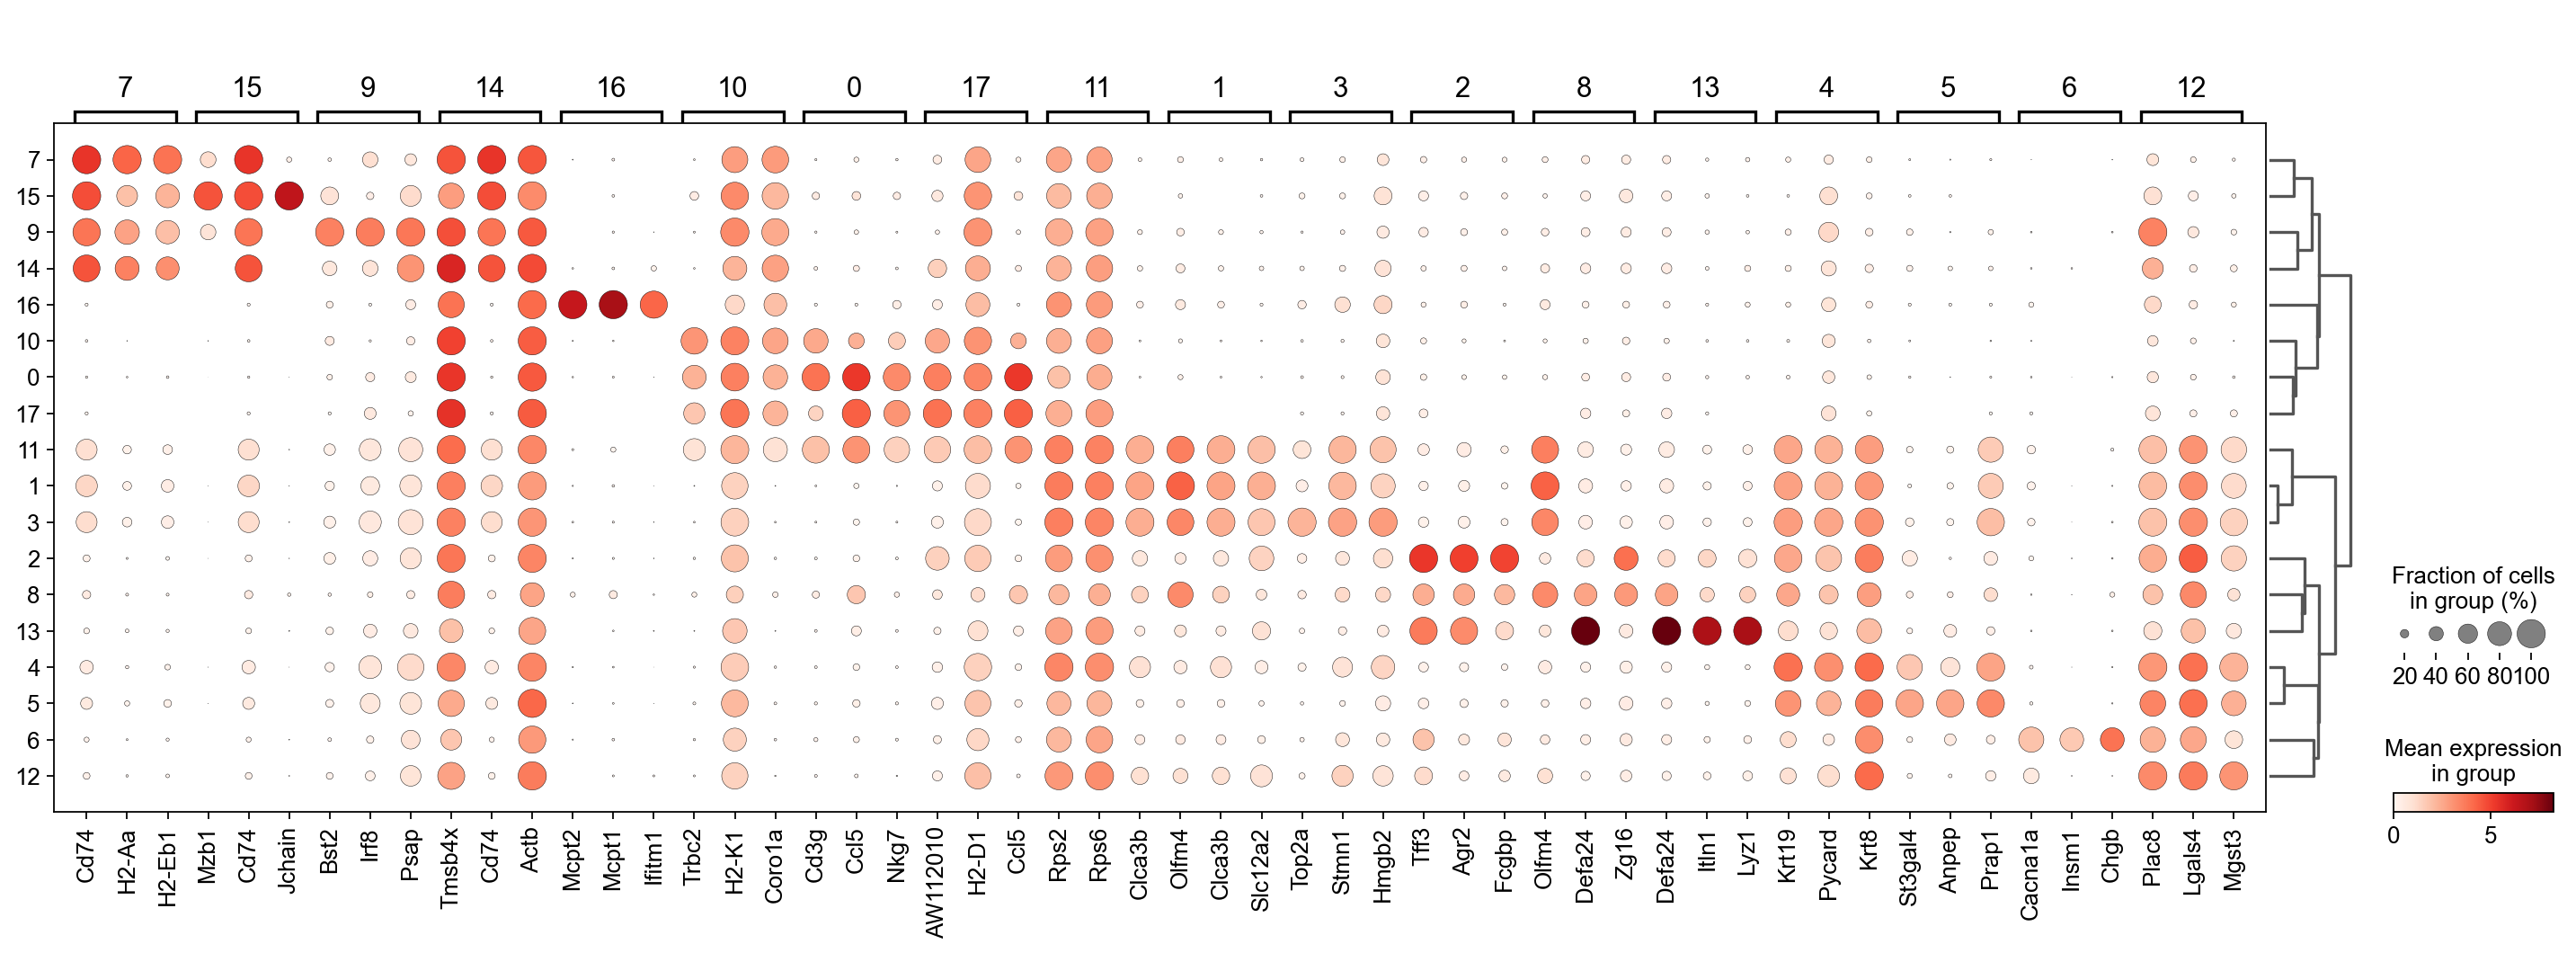

In [9]:
sc.tl.rank_genes_groups(adata1, groupby='Cluster')
sc.pl.rank_genes_groups_dotplot(adata1, n_genes=3)

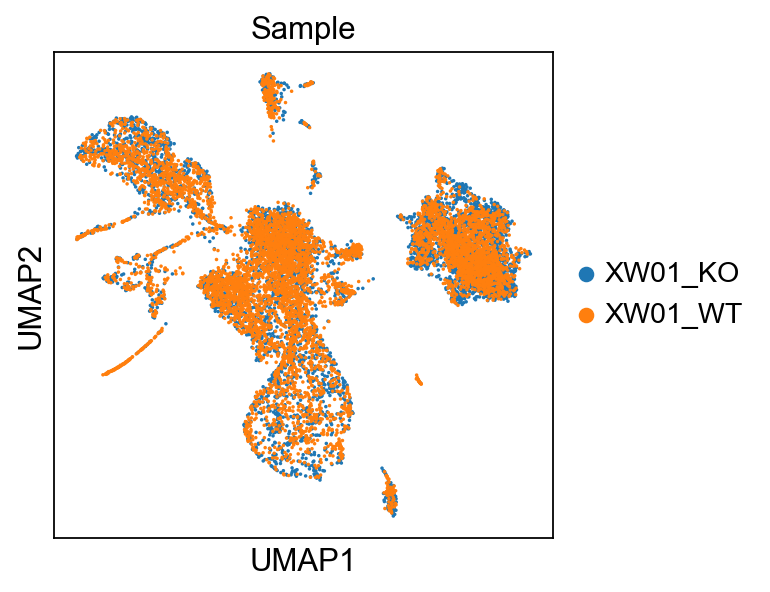

In [10]:
sc.pl.umap(adata1, color='Sample')

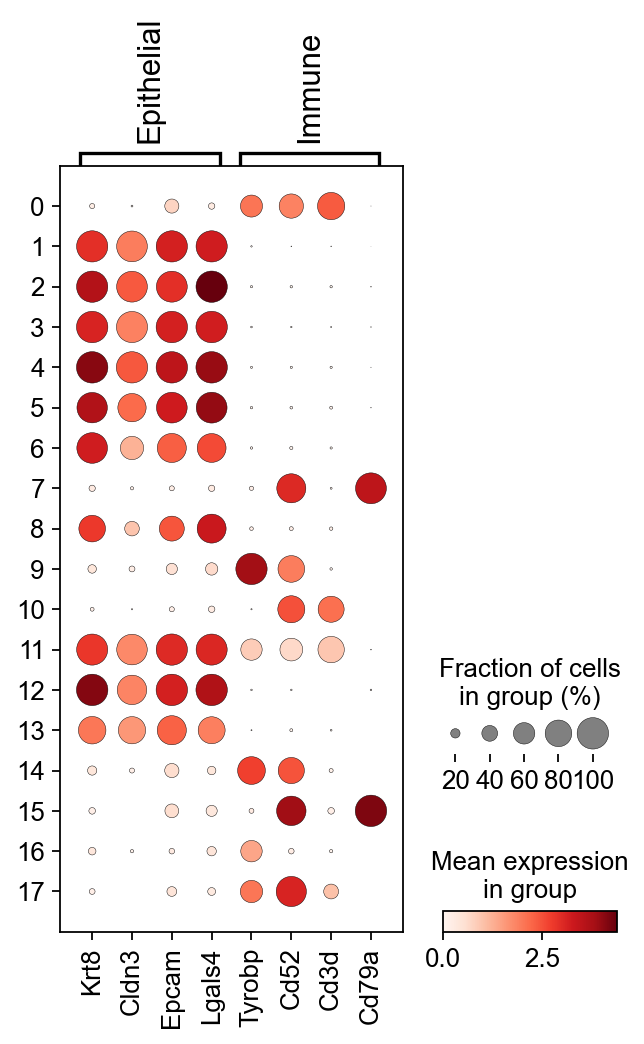

computing score 'Epithelial_score'
    finished: added
    'Epithelial_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'Immune_score'
    finished: added
    'Immune_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)


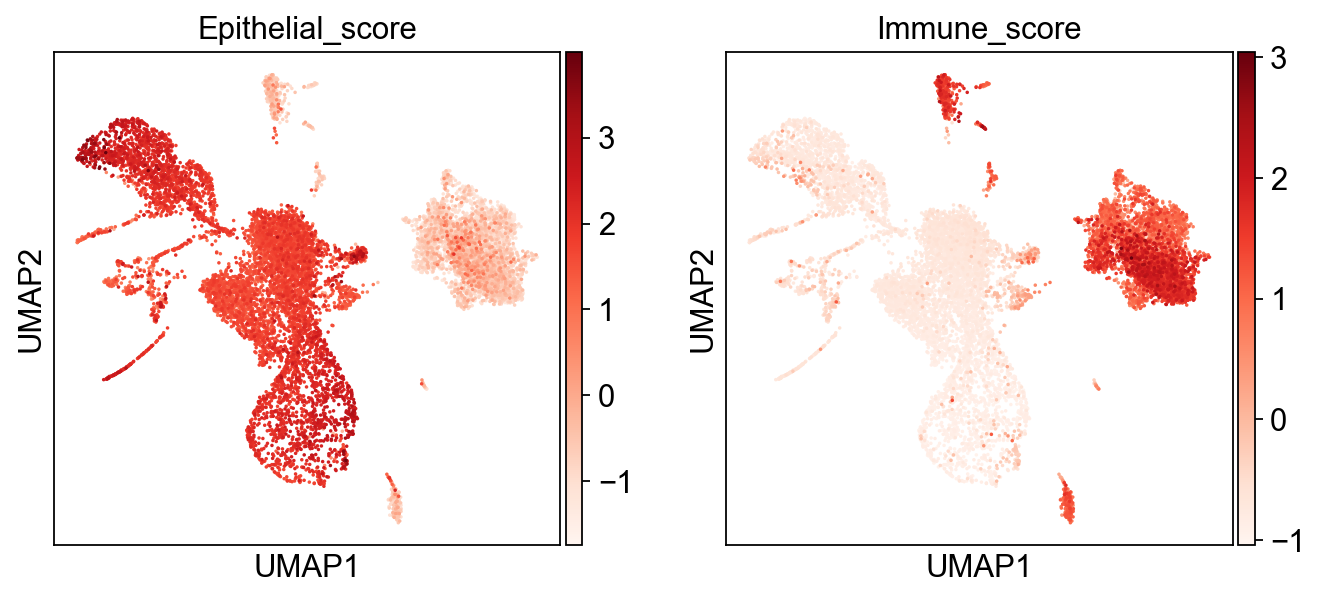

... storing 'Lineage' as categorical


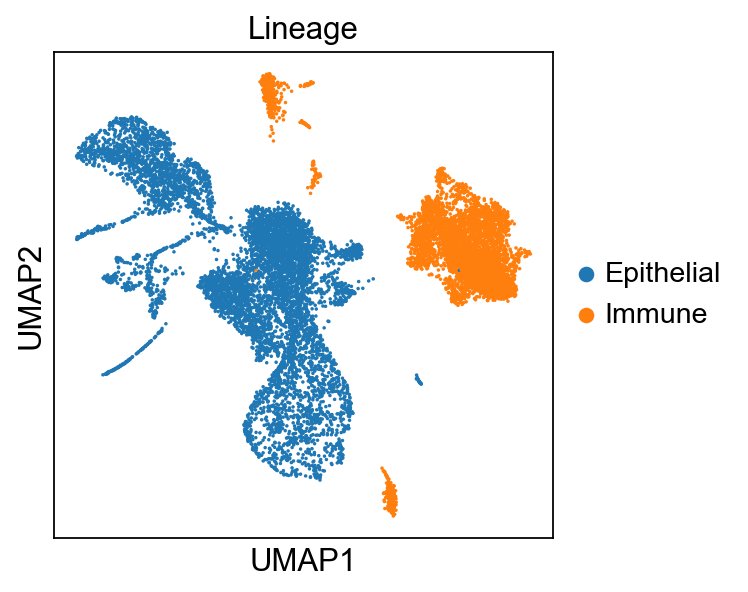

In [12]:
def label_lineages(adata, cluster_key='Cluster'):
    lineage_markers = {
        'Epithelial':['Krt8','Cldn3','Epcam','Lgals4'],
        'Immune':['Tyrobp','Cd52','Cd3d','Cd79a']
    }
    sc.pl.dotplot(adata, groupby=cluster_key, var_names = lineage_markers)

    score_names = []
    for lineage, genes in lineage_markers.items():
        score_name = lineage + '_score'
        score_names += [score_name]
        sc.tl.score_genes(adata, gene_list=genes, score_name=score_name)

    sc.pl.umap(adata, color=score_names)


    # Looking at the markers, it seems like each cluster can be easily classified into Immune or Epithelial lineages
    # We will use K-means clustering to achieve this automatically

    df = adata.obs.loc[:,['Immune_score']]
    df[cluster_key] = adata.obs[cluster_key]
    df = df.groupby(cluster_key).agg('mean')
    
    from sklearn.cluster import KMeans
    X = df.values
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    df['label'] = kmeans.labels_
    label_dict = {df.groupby('label').agg('mean')['Immune_score'].idxmax():'Immune',
                  df.groupby('label').agg('mean')['Immune_score'].idxmin():'Epithelial'}
    df['lineage'] = df['label'].replace(label_dict)
    
    adata.obs['Lineage'] = adata.obs[cluster_key].replace(df.to_dict()['lineage'])


    sc.pl.umap(adata, color='Lineage')
    
label_lineages(adata1)

Generating an SVM using  a gaussian kernel ...
Generating log(CPM + 1) matrix...
Using raw data in adata_train.raw
adata.raw.var_names matches adata.var_names
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
Excluding 25 marker genes that do not appear in target dataset
Excluded g

... storing 'Predicted_Cell_Type' as categorical


Adding predicted cell type to adata.obs['Predicted_Cell_Type']


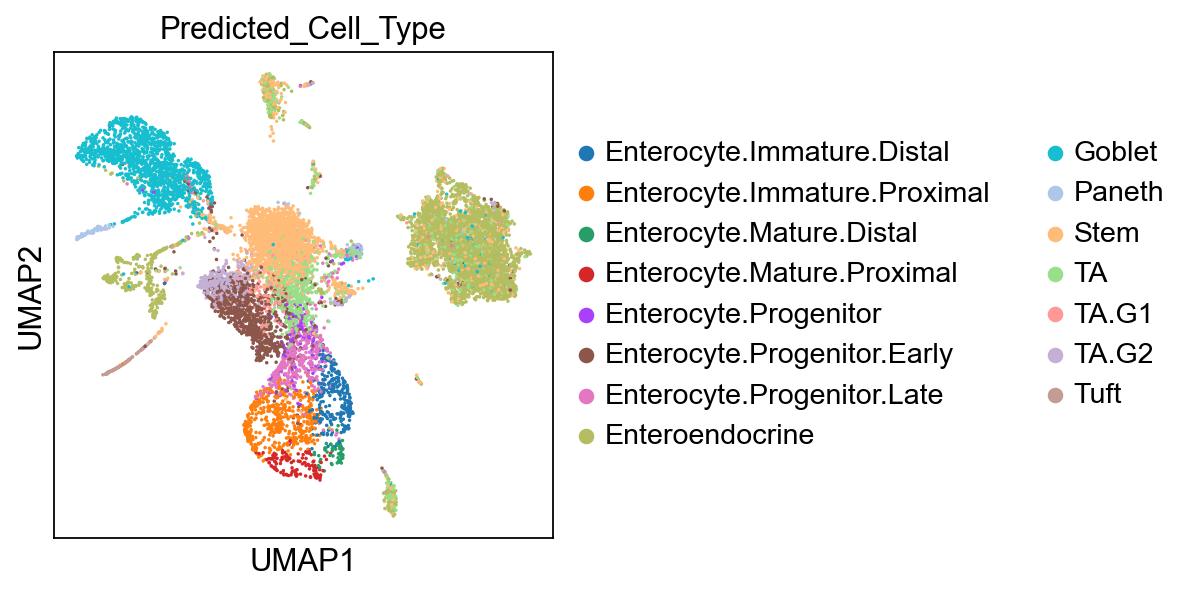

In [13]:
transfer_cell_types_svm(adata_ref=reg,
                        adata_target=adata1,
                        cell_type_key='Regev_Cluster',
                        kernel='rbf')


... storing 'Predicted_Cell_Type' as categorical


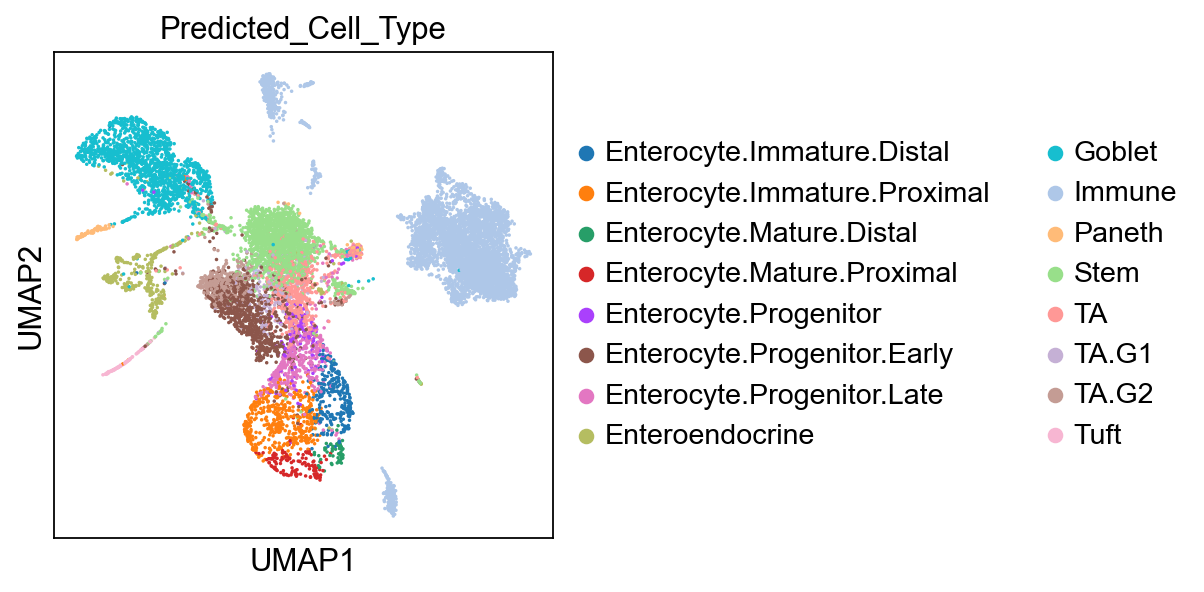

... storing 'Cell_Type' as categorical


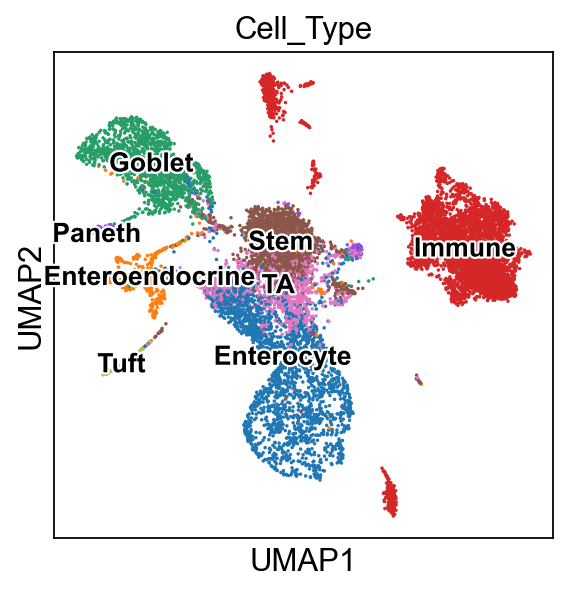

In [14]:
immune_mask = adata1.obs['Lineage'] == 'Immune'
adata1.obs['Predicted_Cell_Type'] = adata1.obs['Predicted_Cell_Type'].astype('str').mask(immune_mask,'Immune')
sc.pl.umap(adata1, color='Predicted_Cell_Type')

relabel = adata1.obs['Predicted_Cell_Type'].str.split('.').str[0]
relabel = relabel.replace({"Late_EE":'Enteroendocrine'})

adata1.obs['Cell_Type'] = relabel
sc.pl.umap(adata1, color='Cell_Type', legend_loc='on data', legend_fontsize=12, legend_fontoutline=2)

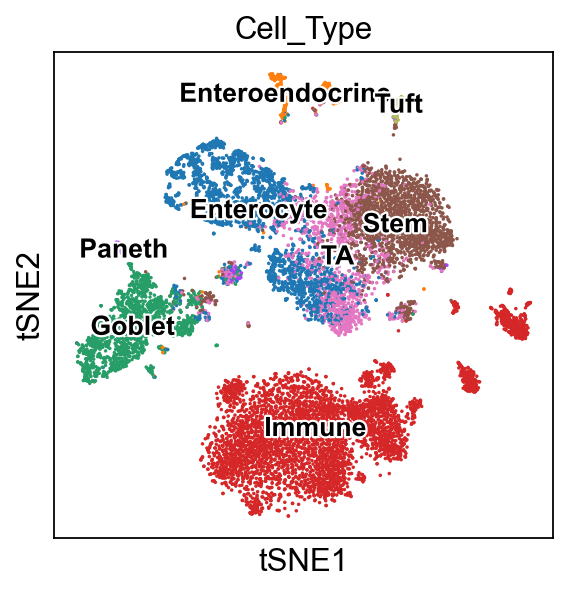

In [15]:
sc.pl.tsne(adata1, color='Cell_Type', legend_loc='on data', legend_fontsize=12, legend_fontoutline=2)

# C11orf53 knockout scRNAs-seq replicate 2

reading /Users/jpreall/Dropbox/Preall_Lab/Vakoc/XW02/aggr/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Detected 2 GEM groups. Adding key 'Sample' to obs dataframe.
XW02_KO    9444
XW02_WT    7846
Name: Sample, dtype: int64
filtered out 10848 genes that are detected in less than 1 cells
Filtering cells with fraction mitochondrial reads > 0.2
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Itln1', 'Mptx2', 'Gcg', 'Chgb', 'Car1', 'Reg4', 'Fabp2', 'Clca1', 'Spink4', 'Reg3b', 'Reg1', 'Reg3g', 'Ghrl', 'Fcgbp', 'Zg16', 'Sct', 'Muc2', 'Defa21', 'Gm14851', 'Defa30', 'Defa22', 'AY761184', 'Defa24', 'Apoa1', 'Cck', 'Nts', 'Lyz1', 'Fabp6', 'Ccl6', 'Gip', 'Agr2', 'Chga', 'Gzma', 'Ang4', 'Olfm4', 'Sst', 'Tff3', 'Gm42418', 'Malat1', 'Fth1', 'mt-Co1', 'mt-Atp6', 'mt-Co3', 'mt-Cytb']
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions'

/opt/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:38)
running Leiden clustering
    finished: found 14 clusters and added
    'Cluster', the cluster labels (adata.obs, categorical) (0:00:01)


... storing 'Sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


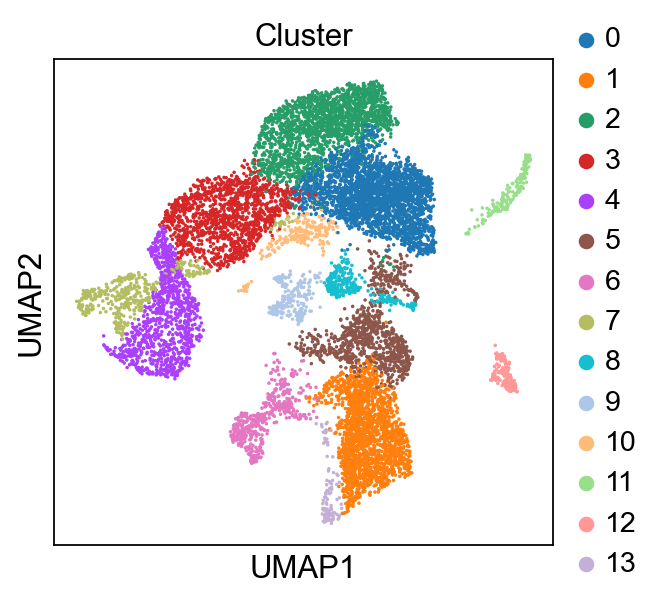

In [16]:
adata2 = sc.read_10x_h5('/Users/jpreall/Dropbox/Preall_Lab/Vakoc/XW02/aggr/filtered_feature_bc_matrix.h5')
import_cellranger_aggrcsv(adata2, '/Users/jpreall/Dropbox/Preall_Lab/Vakoc/XW02/aggr/aggregation.csv')
print(adata2.obs['Sample'].value_counts())
adata2 = scanpy_recipe(adata2, mito_max=0.2)

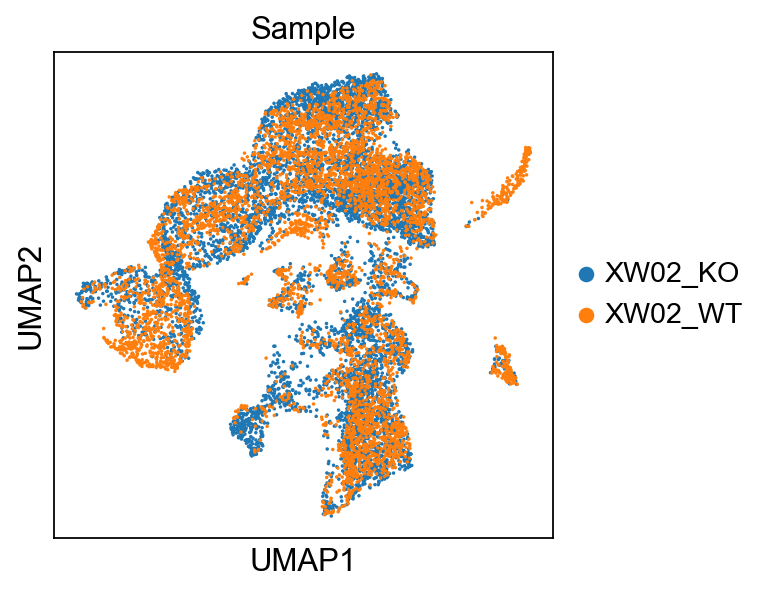

In [17]:
sc.pl.umap(adata2, color='Sample')

Generating an SVM using  a gaussian kernel ...
Generating log(CPM + 1) matrix...
Using raw data in adata_train.raw
adata.raw.var_names matches adata.var_names
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
Excluding 25 marker genes that do not appear in target dataset
Excluded g

... storing 'Predicted_Cell_Type' as categorical


Adding predicted cell type to adata.obs['Predicted_Cell_Type']


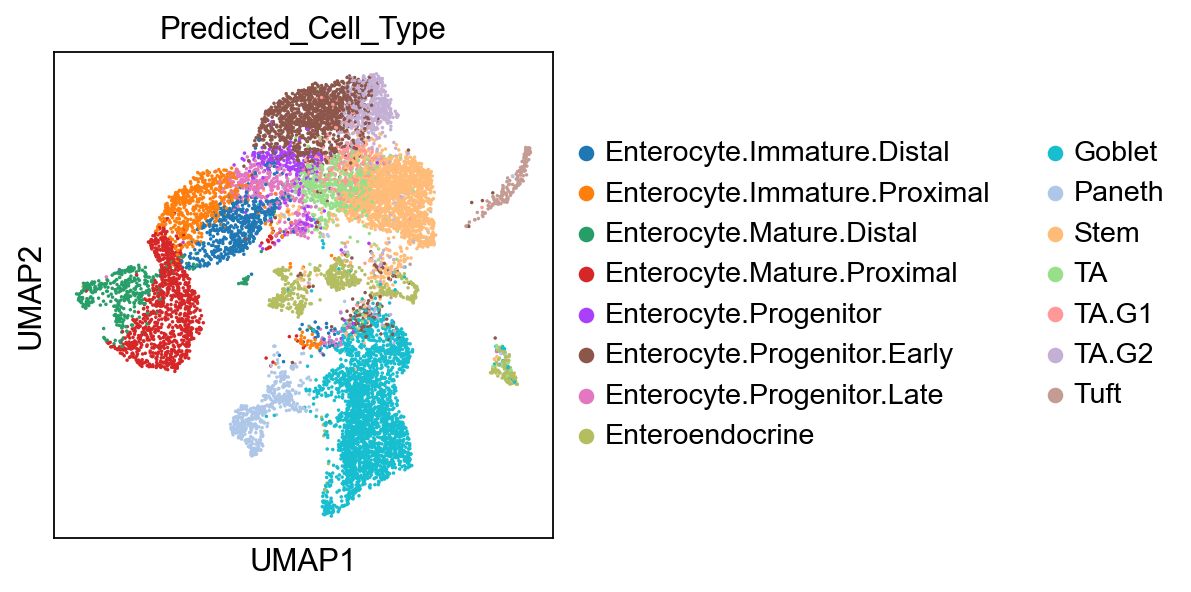

In [18]:
transfer_cell_types_svm(adata_ref=reg, adata_target=adata2, cell_type_key='Regev_Cluster', kernel='rbf')

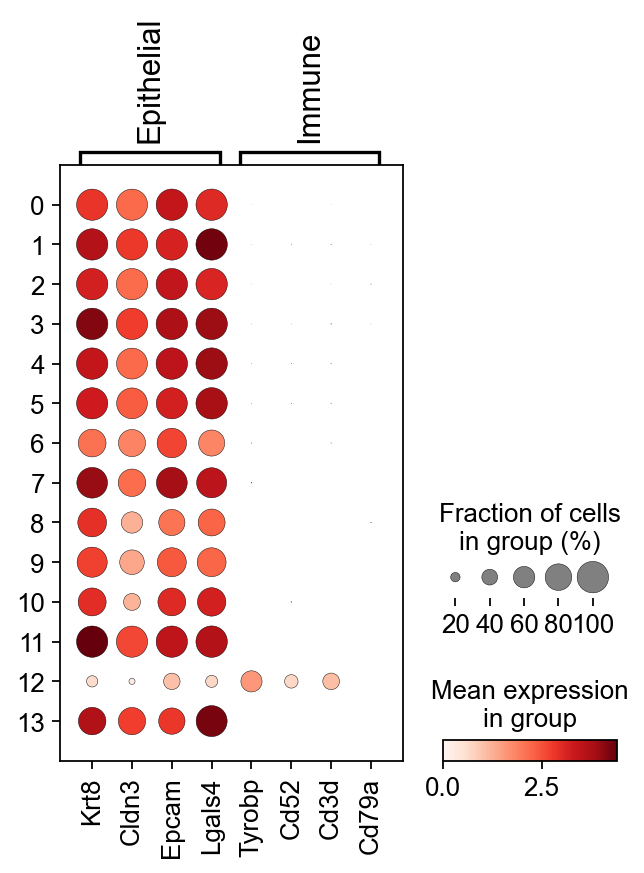

computing score 'Epithelial_score'
    finished: added
    'Epithelial_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score 'Immune_score'
    finished: added
    'Immune_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)


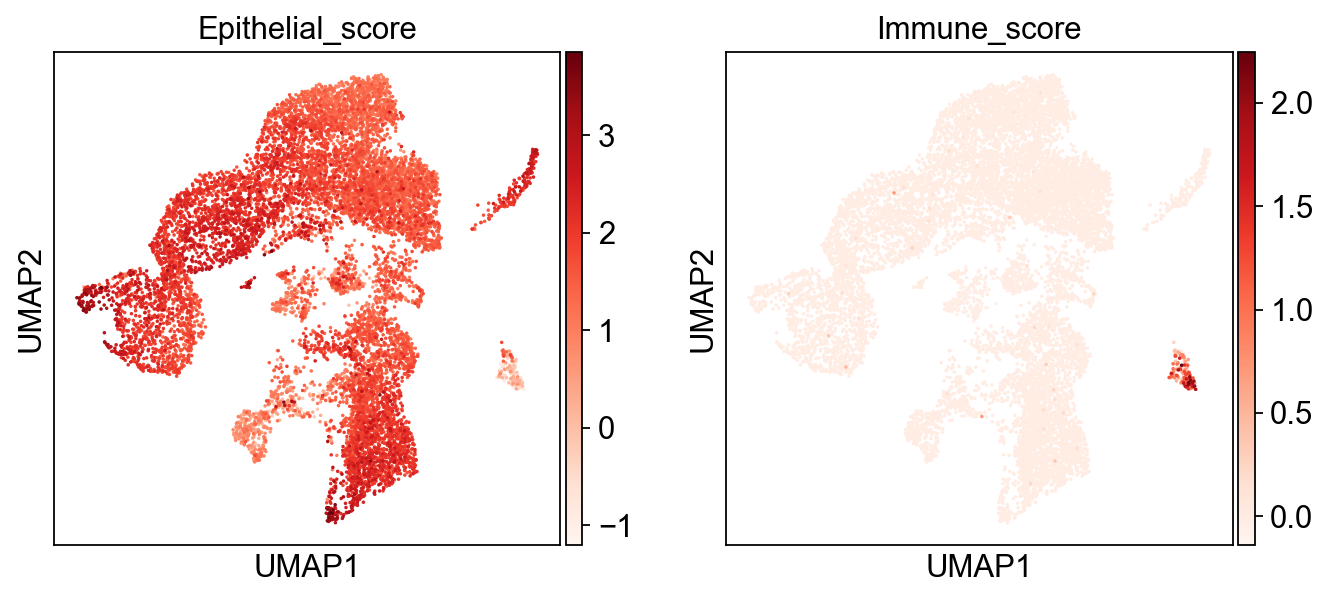

... storing 'Lineage' as categorical


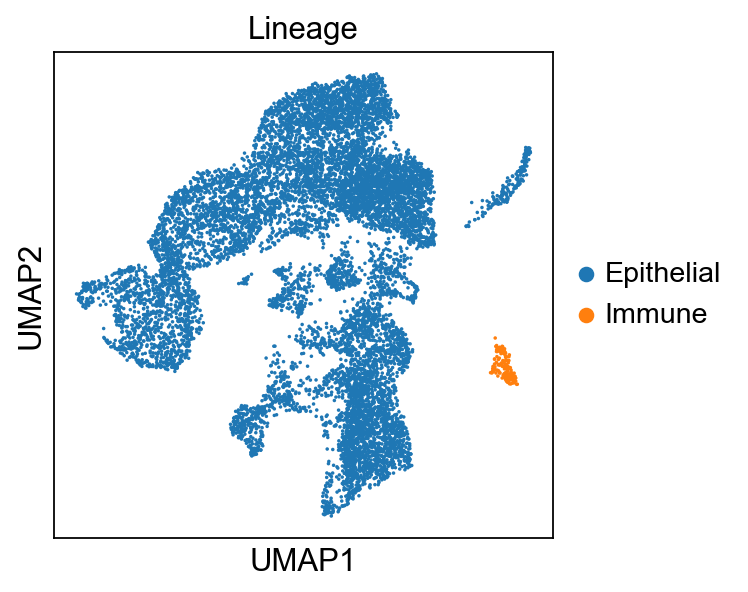

In [19]:
label_lineages(adata2)

... storing 'Predicted_Cell_Type' as categorical


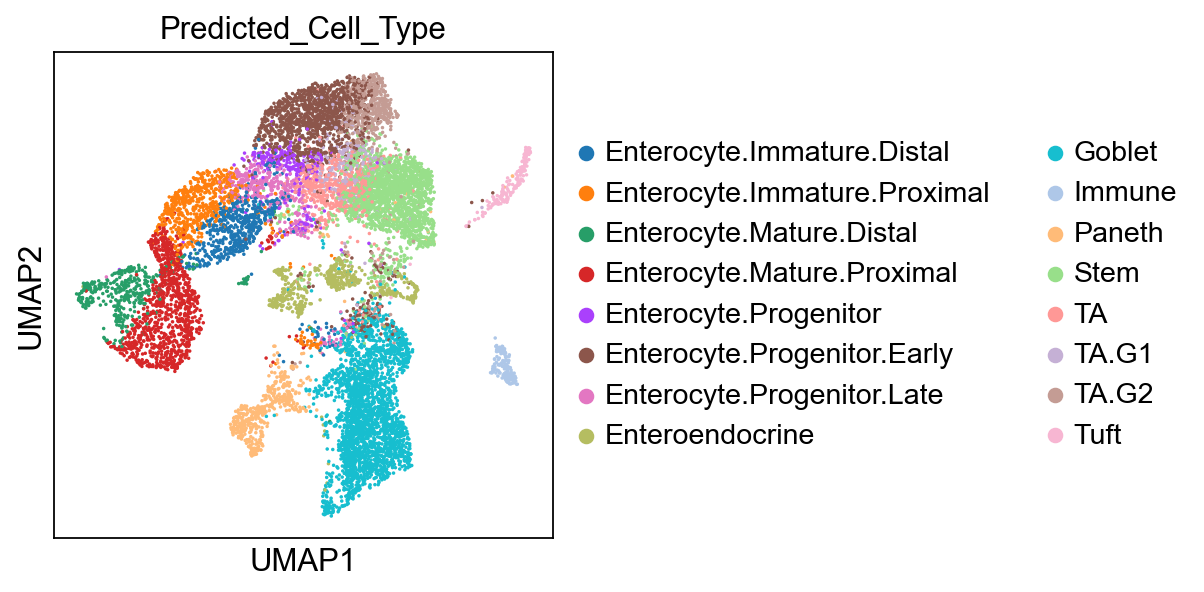

... storing 'Cell_Type' as categorical


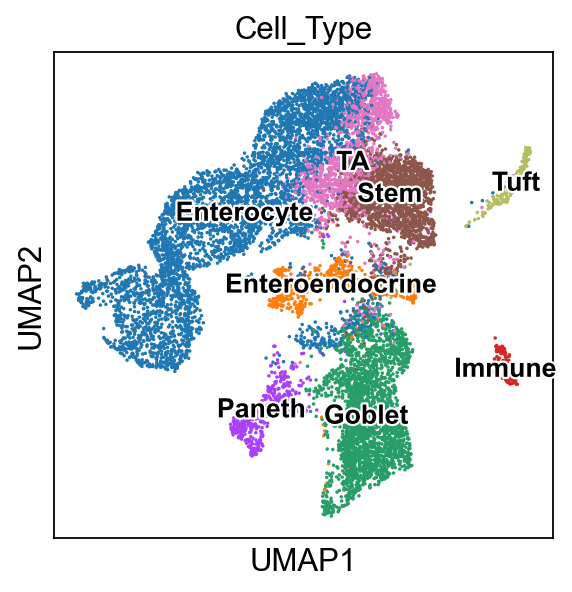

In [20]:
immune_mask = adata2.obs['Lineage'] == 'Immune'
adata2.obs['Predicted_Cell_Type'] = adata2.obs['Predicted_Cell_Type'].astype('str').mask(immune_mask,'Immune')
sc.pl.umap(adata2, color='Predicted_Cell_Type')

relabel = adata2.obs['Predicted_Cell_Type'].str.split('.').str[0]
relabel = relabel.replace({"Late_EE":'Enteroendocrine'})

adata2.obs['Cell_Type'] = relabel
sc.pl.umap(adata2, color='Cell_Type', legend_loc='on data', legend_fontsize=12, legend_fontoutline=2)

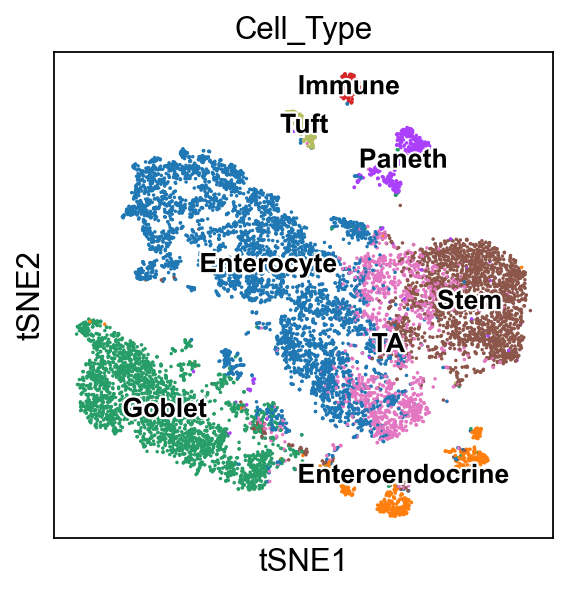

In [21]:
sc.pl.tsne(adata2, color='Cell_Type', legend_loc='on data', legend_fontsize=12, legend_fontoutline=2)